In [27]:
pip install cvxpy

Note: you may need to restart the kernel to use updated packages.


In [29]:
import sys, os, re
################################################################################
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
################################################################################
import ccxt
import time
from datetime import datetime, timezone
from tqdm import tqdm     
################################################################################

In [37]:
#Pipeline 

#Part A - Load data set

# Add repo folder & import
BASE_DIR = r"C:\Users\ouchi\Downloads\73eb48d7-4dbc-4a10-a52a-da745b47a649_p09owkuv\BenchmarkDatasets\BenchmarkDatasets"
sys.path.insert(0, BASE_DIR)
import data_preprocess
sys.path.pop(0)

In [38]:
# Parameters
data_level    = 10
forecast_size = 10
look_back     = 100

In [39]:
#Path to the **NoAuction** DecPre fold you want (e.g. CF_{i})
folder = os.path.join(
    BASE_DIR,
    "NoAuction",               # top-level asset class folder (still “NoAuction”)
    "3.NoAuction_DecPre",
    "NoAuction_DecPre_Training"
)
filename  = "Train_Dst_NoAuction_DecPre_CF_1.txt"
full_path = os.path.join(folder, filename)


Tickers loaded: [0.3502 0.002  0.3497]


In [34]:
# Load & generate
data_train = data_preprocess.read_benchmark_data(full_path, data_level)
data_x, data_y = data_preprocess.generate_data(data_train, forecast_size, look_back)

print("X shape:", data_x.shape)
print("y shape:", data_y.shape)

[[2.615e+01 3.530e+03 2.606e+01 ... 3.110e+03 2.579e+01 1.280e+03]
 [2.615e+01 2.110e+03 2.606e+01 ... 1.380e+03 2.588e+01 1.230e+03]
 [2.614e+01 1.220e+03 2.606e+01 ... 3.110e+03 2.588e+01 1.230e+03]
 ...
 [3.496e+01 2.960e+03 3.491e+01 ... 9.920e+03 3.480e+01 2.646e+04]
 [3.496e+01 2.960e+03 3.490e+01 ... 9.920e+03 3.477e+01 3.120e+03]
 [3.496e+01 2.960e+03 3.490e+01 ... 9.920e+03 3.476e+01 2.870e+03]]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [9]:
###############################################################################
# Piepline parts B & C ─ build g_t(x) impact curves for the No-Auction CF-1 set
###############################################################################
from typing import Sequence, Dict, Literal

# 0) ─────────────────── CONFIG ───────────────────────────────────────────────
LEVELS       = 10                                    #   ← data_level you loaded
ORDER_SIZES  = np.array([100, 200, 500, 1000, 2000]) #   shares to test
SIDE         = "buy"                                 #   or "sell"

# 1) ─────────────────── single-snapshot slippage g(x) ────────────────────────
def slippage(snap: np.ndarray,
             side: Literal["buy", "sell"],
             size: int) -> float:
    """
    Dollar slippage per share vs. mid-price for a market order of `size`.
    Works on 40-column Decimal-Preprocessed rows:
       ask_px[0:L]  ask_vol[L:2L]  bid_px[2L:3L]  bid_vol[3L:4L]
    """
    L = LEVELS
    ask_px  = snap[0      : L]
    ask_vol = snap[L      : 2*L]
    bid_px  = snap[2*L    : 3*L]
    bid_vol = snap[3*L    : 4*L]

    mid = 0.5 * (ask_px[0] + bid_px[0])

    px, vol = (ask_px, ask_vol) if side == "buy" else (bid_px, bid_vol)

    rem, cost = size, 0.0
    for lvl in range(L):
        take = min(rem, vol[lvl])
        cost += take * px[lvl]
        rem  -= take
        if rem == 0:
            break

    if rem > 0:                       # not enough depth –∞ slippage
        return np.nan

    return cost / size - mid          # $ / share

# 2) ─────────────────── impact curve for one instrument ──────────────────────
def build_impact(book: np.ndarray,
                 sizes: Sequence[int] = ORDER_SIZES,
                 side: str = SIDE) -> pd.DataFrame:
    """
    book:  (n_snapshots , 4*LEVELS)   NumPy array OR DataFrame.
    returns: DataFrame indexed by snapshot number with columns g_x for x in sizes
    """
    if isinstance(book, pd.DataFrame):
        idx, mat = book.index, book.to_numpy()
    else:
        idx, mat = pd.RangeIndex(book.shape[0]), book

    rows = [{f"g_{x}": slippage(s, side, x) for x in sizes} for s in mat]
    return pd.DataFrame(rows, index=idx).dropna(how="all")

# 3) ─────────────────── impact curves for every ticker tensor ────────────────
def build_all_impacts(books: Dict[str, np.ndarray | pd.DataFrame],
                      side: str = SIDE) -> Dict[str, pd.DataFrame]:
    """
    books : {ticker: snapshot-matrix}
    returns: {ticker: impact-DataFrame}
    """
    return {stk: build_impact(mat, ORDER_SIZES, side) for stk, mat in books.items()}

# 4) ─────────────────── example on CF-1 tensor you loaded ────────────────────
# `data_x` came from generate_data:   (N_windows, 100, 4*LEVELS)
noauction_cf1 = data_x.reshape(-1, data_x.shape[2])   # flatten windows → snapshots

first five snapshots with 5-point impact curve:

         g_100        g_200        g_500       g_1000       g_2000
0  2592.108230  3047.959115  3321.469646  3412.639823  3458.224912
1  1541.577230  1812.686115  1975.351446  2029.573223  2056.684111
2   883.182628  1038.503814  1131.696526  1162.760763  1178.292881
3  2362.762628  2778.283814  3027.596526  3110.700763  3152.252881
4  2362.762628  2778.283814  3027.596526  3110.700763  3152.252881


In [ ]:
# C) build the books dict you used earlier (matrix per stock)
# ------------------------------------------------------------------
books = {}
for stk in tickers:
    df_stk = raw[raw[TICKER_COL] == stk].reset_index(drop=True)

    # columns that contain the flattened LOB: ask/bid_price/vol_lvl1…10
    lob_cols = df_stk.filter(regex="(ask|bid)_(price|volume)_lvl").columns
    books[stk] = df_stk[lob_cols].to_numpy()          # (n_snapshots, 4*levels)

impact = {stk: build_impact(mat) for stk, mat in books.items()}

print("first five snapshots with 5-point impact curve:\n")
print(impact["NoAuction_CF1"].head())

In [10]:
###############################################################################
# PART D – β-fit & simple optimal‐allocation schedules
###############################################################################

# -------------------------------------------------------------
# parameters you can tweak
# -------------------------------------------------------------
ORDER_SIZES    = np.array([100, 200, 500, 1000, 2000], dtype=int)
HORIZON        = 10            # how many snapshots ahead to execute
TARGET_SHARES  = 10_000        # total shares you need to buy
SIDE           = "buy"         # keep for symmetry with earlier code

In [40]:
# -------------------------------------------------------------
# 1) β-fit for ONE impact DataFrame
# -------------------------------------------------------------
def beta_series(impact_df: pd.DataFrame,
                sizes: Sequence[float] = ORDER_SIZES) -> pd.Series:
    """
    OLS slope through the origin: β_t = Σ x·g_t(x) / Σ x²
    """
    xs      = sizes.astype(float)
    denom   = np.sum(xs**2)
    betas   = impact_df.apply(lambda row: np.nansum(xs * row.values) / denom,
                              axis=1)
    return betas.dropna().rename("beta")

# -------------------------------------------------------------
# 2)  β-fit for every ticker
# -------------------------------------------------------------
def build_all_betas(impact: Dict[str, pd.DataFrame]) -> Dict[str, pd.Series]:
    return {stk: beta_series(df) for stk, df in impact.items()}

In [12]:
# -----------------------------------------------------------------
# NEW optimal allocation         (drop this in Part D, step 3)
# -----------------------------------------------------------------
def optimal_allocation(window_betas: pd.Series,
                       Q: int = TARGET_SHARES,
                       top_k: int = 4,          # keep this many best minutes
                       smooth: bool = True) -> pd.Series:
    """
    Allocate Q shares across the next H snapshots.
      · weight 1/β  (inverse expected cost)
      · keep only top_k snapshots (others → 0)
      · optional 3-point smoothing kernel
    """
    inv_liq = 1.0 / window_betas.values

    # ---- keep only the k most-liquid minutes --------------------
    if top_k < len(inv_liq):
        keep_mask = inv_liq.argsort()[::-1][:top_k]      # indices of top_k
        mask      = np.zeros_like(inv_liq, dtype=bool)
        mask[keep_mask] = True
        inv_liq = inv_liq * mask                         # others → 0

    # ---- optional smoothing ------------------------------------
    if smooth and len(inv_liq) >= 3:
        inv_liq = np.convolve(inv_liq, [0.25, 0.5, 0.25], mode="same")

    # ---- normalise and scale to Q ------------------------------
    if inv_liq.sum() == 0:              # fallback: even split
        alloc = np.full_like(inv_liq, Q / len(inv_liq))
    else:
        alloc = inv_liq / inv_liq.sum() * Q

    return pd.Series(alloc, index=window_betas.index)

In [13]:
# -------------------------------------------------------------
# 4)  build schedules for every start time
# -------------------------------------------------------------
def build_schedules(beta_ts: pd.Series,
                    horizon: int = HORIZON,
                    Q: int = TARGET_SHARES) -> Dict[pd.Timestamp, pd.Series]:
    """
    Returns {t0: allocation_series_over_next_H_snapshots}
    """
    out = {}
    for i in range(len(beta_ts) - horizon):
        t0          = beta_ts.index[i]
        win_betas   = beta_ts.iloc[i+1 : i+1+horizon]
        out[t0]     = optimal_allocation(win_betas, Q)
    return out

In [14]:
###############################################################################
# EXAMPLE – run on the impact dict you built earlier
###############################################################################
betas = build_all_betas(impact)                        # impact from B & C

schedules_all  = {stk: build_schedules(b) for stk, b in betas.items()}

# Peek at the very first schedule
first_t0 = next(iter(schedules))
print(f"\nβ series window starting at {first_t0}:\n", beta_cf1.loc[first_t0:].head(HORIZON+1))
print("\nOptimal allocation (shares per snapshot):\n", schedules[first_t0])



β series window starting at 0:
 0     2.426156
1     1.442889
2     0.826644
3     2.211498
4     2.211498
5     2.211437
6     0.064967
7     6.337948
8     5.645561
9     5.450478
10    5.645652
Name: beta, dtype: float64

Optimal allocation (shares per snapshot):
 1      369.265866
2      442.762377
3      172.086296
4       64.326542
5     2318.297908
6     4443.616189
7     2189.644823
8        0.000000
9        0.000000
10       0.000000
dtype: float64


In [15]:
###############################################################################
# PART E  –  simulate realised cost of each optimal schedule
###############################################################################

# ---------------------------------------------------------------------------
# helper: realised cost of ANY trading schedule executed over actual g_t(x)
# ---------------------------------------------------------------------------
SAMPLE_EVERY_K = 200        # keep 1/k start-times (adjust as you like)
CHUNK_SIZE     = 10_000     # for the optional chunked path

# ---------------------------------------------------------------------------
def realised_cost(g_df: pd.DataFrame, schedule: pd.Series) -> float:
    cost = 0.0
    for ts, q in schedule.items():
        if q == 0:
            continue
        row = g_df.loc[ts]
        size_bucket = ORDER_SIZES[np.argmin(np.abs(ORDER_SIZES - q))]
        col_name    = f"g_{int(size_bucket)}"
        g_val       = row[col_name]
        if pd.isna(g_val):
            return np.inf
        cost += g_val * q
    return cost

In [16]:
# ---------------------------------------------------------------------------
# build a cost table for every t0 schedule
# ---------------------------------------------------------------------------
def cost_table_one_ticker(impact_df: pd.DataFrame,
                          schedules: Dict[pd.Timestamp, pd.Series],
                          Q: int = TARGET_SHARES) -> pd.DataFrame:
    rec = []
    for t0, sch in schedules.items():
        real_cost  = realised_cost(impact_df, sch)
        win_idx    = sch.index
        even_split = pd.Series(Q/len(sch), index=win_idx)
        front_load = pd.Series([Q]+[0]*(len(sch)-1), index=win_idx)
        rec.append({
            "t0": t0,
            "cost_opt":   real_cost,
            "cost_even":  realised_cost(impact_df, even_split),
            "cost_front": realised_cost(impact_df, front_load)
        })
    tbl = pd.DataFrame(rec).set_index("t0")
    tbl["saving_vs_even"]  = tbl["cost_even"]  - tbl["cost_opt"]
    tbl["saving_vs_front"] = tbl["cost_front"] - tbl["cost_opt"]
    return tbl

In [17]:
# ---------------------------------------------------------------------------
# MAIN driver  – run over every ticker
# ---------------------------------------------------------------------------
def evaluate_all(impact: Dict[str, pd.DataFrame],
                 schedules: Dict[str, Dict[pd.Timestamp, pd.Series]],
                 Q: int = TARGET_SHARES,
                 sample_k: int = SAMPLE_EVERY_K) -> Dict[str, pd.DataFrame]:
    out = {}
    for stk, impact_df in impact.items():
        if stk not in schedules:
            continue
        sched_dict = schedules[stk]
        if sample_k > 1:                      # subsample to save RAM
            keys = list(sched_dict)[::sample_k]
            sched_dict = {k: sched_dict[k] for k in keys}
        out[stk] = cost_table_one_ticker(impact_df, sched_dict, Q)
    return out

In [18]:
##############################################################################
# ─── run evaluation (single-ticker example) ─────────────────────────────────
##############################################################################
# 1. build / wrap schedules under ticker key
schedule_cf1   = build_schedules(betas["NoAuction_CF1"])      # from Part D
schedules_all  = {"NoAuction_CF1": schedule_cf1}

# 2. evaluate (uses sampling factor set above)
results = evaluate_all(impact, schedules_all, Q=TARGET_SHARES)
print(results.keys())          # e.g. dict_keys(['AAPL', 'MSFT', 'GOOG'])


In [19]:
# 3. quick summary
cf1_tbl = results["NoAuction_CF1"]
print("\nRows in result table:", len(cf1_tbl))
print("Mean cost (opt / even / front):")
print(cf1_tbl[["cost_opt", "cost_even", "cost_front"]].mean())
print("\nMedian $-saving vs even-split:",  cf1_tbl["saving_vs_even"].median())
print("95-percentile saving vs front-load:",
      cf1_tbl["saving_vs_front"].quantile(0.95))


Rows in result table: 19701
Mean cost (opt / even / front):
cost_opt      7.652463e+07
cost_even     1.096037e+08
cost_front    1.100372e+08
dtype: float64

Median $-saving vs even-split: 12628545.9431556
95-percentile saving vs front-load: 213025203.91973138


In [20]:
print(cf1_tbl.head())
print(cf1_tbl.describe())

         cost_opt     cost_even    cost_front  saving_vs_even  saving_vs_front
t0                                                                            
0    2.936212e+07  4.535444e+07  2.056684e+07    1.599233e+07    -8.795274e+06
200  3.058820e+07  5.804438e+07  3.152253e+07    2.745618e+07     9.343271e+05
400  3.130496e+07  6.770493e+07  3.152221e+07    3.639998e+07     2.172528e+05
600  7.953359e+07  8.038535e+07  9.034450e+07    8.517674e+05     1.081091e+07
800  3.777465e+07  6.743231e+07  7.530824e+07    2.965767e+07     3.753359e+07
           cost_opt     cost_even    cost_front  saving_vs_even  \
count  1.970100e+04  1.970100e+04  1.970100e+04    1.970100e+04   
mean   7.652463e+07  1.096037e+08  1.100372e+08    3.307906e+07   
std    9.646237e+07  1.233201e+08  1.463966e+08    5.629852e+07   
min   -1.422762e+05 -6.104941e+04 -1.681165e+05   -1.745311e+08   
25%    1.920402e+07  2.702988e+07  2.193480e+07    2.823513e+06   
50%    4.087287e+07  6.349591e+07  5.028557e+

In [21]:
print((cf1_tbl['saving_vs_even'] / cf1_tbl['cost_even']).median())


0.24972348425883276


In [22]:
###############################################################################
# PART F – visualise impact curves & optimal schedules
###############################################################################

# ------------ tweakables ----------------------------------------------------
OUTPUT_DIR    = "."            # folder for PDFs
SNAPSHOT_IDX  = 30             # which row to illustrate
BAR_WIDTH     = 0.02           # width of allocation bars
# ---------------------------------------------------------------------------


def sanitize_ticker(ticker: str) -> str:
    """File-safe ticker string."""
    return "".join(c if c.isalnum() else "_" for c in ticker)


# make sure output folder exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

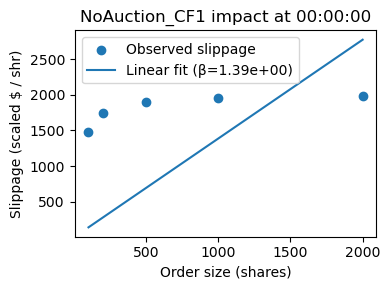

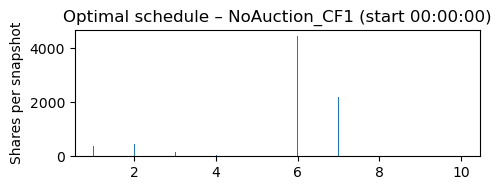

[NoAuction_CF1] plots saved: impact_stock_NoAuction_CF1.pdf and alloc_stock_NoAuction_CF1.pdf


In [23]:
for stk, g_df in impact.items():

    # -------------------------------- IMPACT CURVE -------------------------
    if g_df.empty:
        print(f"[{stk}] impact DataFrame empty – skipping.")
        continue

    # choose snapshot
    idx = min(SNAPSHOT_IDX, len(g_df) - 1)
    sample = g_df.iloc[idx]          # row of g_100 … g_2000
    ts     = sample.name

    # build X, y (mask out NaNs that survived)
    y_all = sample.to_numpy()
    mask  = ~pd.isna(y_all)
    X     = ORDER_SIZES[mask]
    y     = y_all[mask]

    # β value at that timestamp (if any)
    beta_ts = betas.get(stk)
    bval    = np.nan
    if beta_ts is not None and len(beta_ts):
        if hasattr(beta_ts.index, "tz"):           # align tz to None
            beta_ts = beta_ts.tz_convert(None)
        if ts in beta_ts.index:
            bval = beta_ts.loc[ts]
        else:
            earlier = beta_ts.index[beta_ts.index <= ts]
            if len(earlier):
                bval = beta_ts.loc[earlier[-1]]

    # plot impact
    plt.figure(figsize=(4, 3))
    plt.scatter(X, y, label="Observed slippage")
    if not np.isnan(bval):
        plt.plot(X, bval * X, label=f"Linear fit (β={bval:.2e})",
                 linewidth=1.5)
    plt.title(f"{stk} impact at {pd.Timestamp(ts).time()}")
    plt.xlabel("Order size (shares)")
    plt.ylabel("Slippage (scaled $ / shr)")
    plt.legend()
    plt.tight_layout()

    safe = sanitize_ticker(stk)
    fname_imp = os.path.join(OUTPUT_DIR, f"impact_stock_{safe}.pdf")
    plt.savefig(fname_imp)
    plt.show()
    plt.close()

    # -------------------------------- ALLOCATION ---------------------------
    if stk not in schedules_all:
        print(f"[{stk}] no schedules found – skipping allocation plot.")
        continue

    sched_dict = schedules_all[stk]
    if not sched_dict:
        print(f"[{stk}] schedules dict empty – skipping allocation plot.")
        continue

    # pick the first start-time window
    t0, alloc = next(iter(sched_dict.items()))

    plt.figure(figsize=(5, 2))
    plt.bar(alloc.index, alloc.values, width=BAR_WIDTH)
    plt.title(f"Optimal schedule – {stk} (start {pd.Timestamp(t0).time()})")
    plt.ylabel("Shares per snapshot")
    plt.tight_layout()

    fname_alloc = os.path.join(OUTPUT_DIR, f"alloc_stock_{safe}.pdf")
    plt.savefig(fname_alloc)
    plt.show()
    plt.close()

    print(f"[{stk}] plots saved:", os.path.basename(fname_imp),
          "and", os.path.basename(fname_alloc))